In [13]:
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Load & Clean Data


In [15]:
data = pd.read_csv("demand_inventory.csv")
print(data.head())

   Unnamed: 0        Date Product_ID  Demand  Inventory
0           0  2023-06-01         P1      51       5500
1           1  2023-06-02         P1     141       5449
2           2  2023-06-03         P1     172       5308
3           3  2023-06-04         P1      91       5136
4           4  2023-06-05         P1     198       5045


In [16]:
data = data.drop(columns=['Unnamed: 0'])

In [17]:
# Parse 'Date' column and set it as index
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.set_index('Date', inplace=True)

# 2. Exploratory Plots (Plotly)


In [18]:
fig_demand = px.line(
    data.reset_index(),
    x='Date',
    y='Demand',
    title='Demand Over Time'
)
fig_demand.show()

fig_inventory = px.line(
    data.reset_index(),
    x='Date',
    y='Inventory',
    title='Inventory Over Time'
)
fig_inventory.show()

# 3. Time‐Series Diagnostics (ACF/PACF)



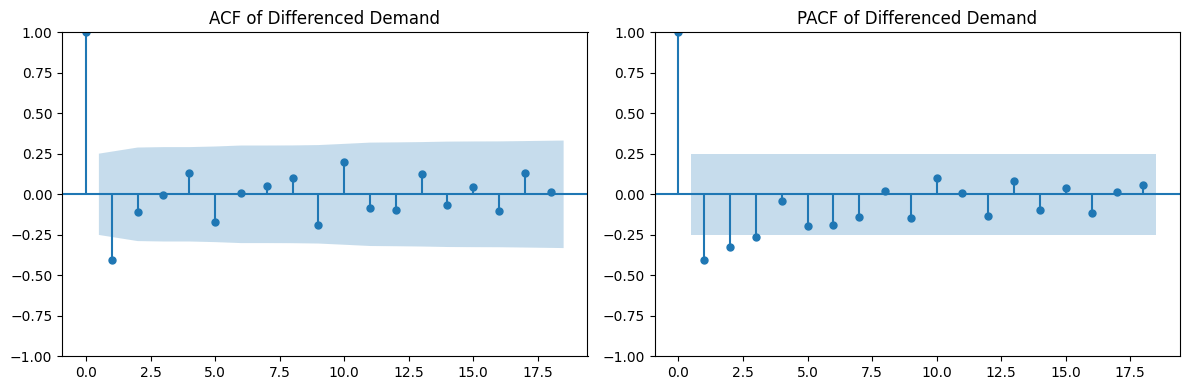

In [19]:
# Use the differenced demand series to check for autocorrelation
differenced = data['Demand'].diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced, ax=axes[0])
axes[0].set_title("ACF of Differenced Demand")
plot_pacf(differenced, ax=axes[1])
axes[1].set_title("PACF of Differenced Demand")
plt.tight_layout()
plt.show()

# 4. Train/Test Split & SARIMAX Evaluation

Test RMSE: 52.32
Test MAE : 47.80
Test MAPE: 44.22%


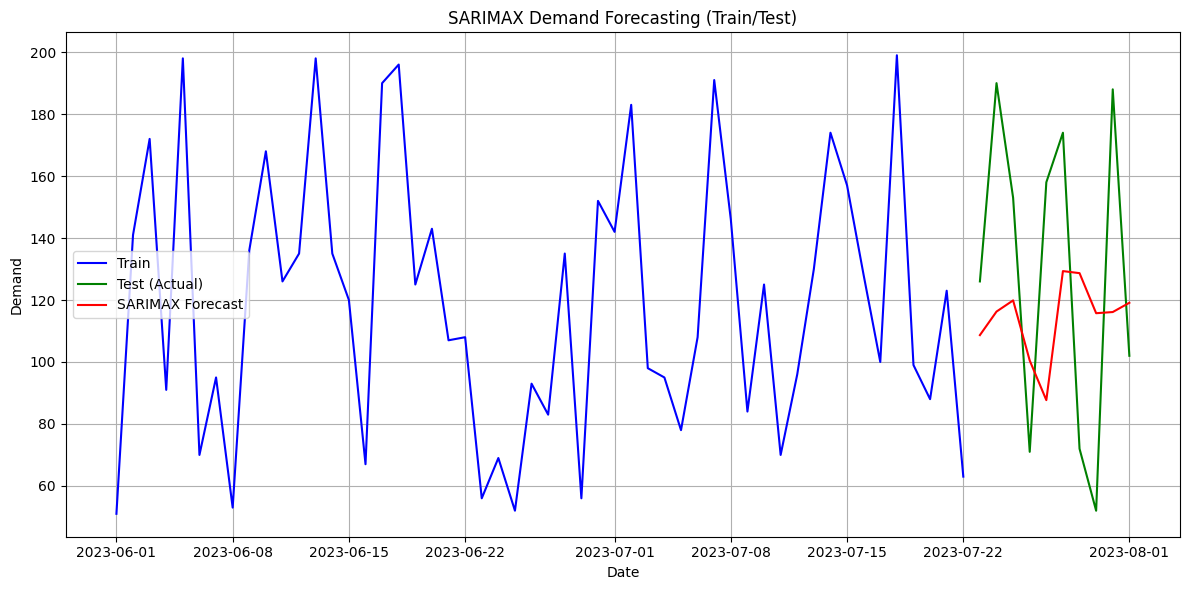

In [20]:
# Reserve the last 10 days as a hold‐out test set
n_test = 10
train = data.iloc[:-n_test]
test = data.iloc[-n_test:]

# Fit SARIMAX on train (seasonal period = 7 days)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)
sarima_model = SARIMAX(train['Demand'],
                       order=order,
                       seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)

# Forecast on the test horizon
forecast_test = sarima_fit.predict(start=test.index[0], end=test.index[-1])

# Compute evaluation metrics on test
rmse = np.sqrt(mean_squared_error(test['Demand'], forecast_test))
mae = mean_absolute_error(test['Demand'], forecast_test)
mape = np.mean(np.abs((test['Demand'] - forecast_test) / test['Demand'])) * 100

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE : {mae:.2f}")
print(f"Test MAPE: {mape:.2f}%")

# Plot train/test vs. forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Demand'], label='Train', color='blue')
plt.plot(test.index, test['Demand'], label='Test (Actual)', color='green')
plt.plot(forecast_test.index, forecast_test, label='SARIMAX Forecast', color='red')
plt.title("SARIMAX Demand Forecasting (Train/Test)")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Refit SARIMAX on the Full Series & Forecast Next 10 Days


In [21]:
# Refit on full data
final_model = SARIMAX(
    data['Demand'],
    order=order,
    seasonal_order=seasonal_order
)
final_fit = final_model.fit(disp=False)

# Forecast the next 10 days (out‐of‐sample)
future_steps = 10
future_forecast = final_fit.predict(
    start=len(data),
    end=len(data) + future_steps - 1
)
# Make them integers (rounded)
future_forecast = future_forecast.round().astype(int)

# Build a date index for those next 10 days
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=future_steps, freq='D')
future_forecast.index = future_dates

print("\nNext 10‐Day Forecasted Demand:")
print(future_forecast)



Next 10‐Day Forecasted Demand:
2023-08-02     90
2023-08-03    114
2023-08-04    149
2023-08-05    109
2023-08-06    101
2023-08-07    151
2023-08-08    124
2023-08-09     93
2023-08-10    112
2023-08-11    147
Freq: D, Name: predicted_mean, dtype: int64


# 6. Inventory‐Optimization (Newsvendor‐Style)


In [22]:
# (a) Newsvendor formulas to compute reorder point, safety stock, etc.

# Example parameters (adjust per your business)
initial_inventory =  data['Inventory'].iloc[-1]  # last observed inventory
lead_time = 1           # days (adjust as needed)
service_level = 0.95    # e.g. 95% service level

# For a “Newsvendor” approach, we approximate a z‐score from a normal assumption.
# Here, we’ll use the quantile of the forecast distribution as a proxy for z.
# (Note: ideally, z = norm.ppf(service_level), but if your forecast distribution is not
#  normal, you could approximate from historical forecast errors. Below we simply
#  take the (1–service_level) percentile of the point‐forecasted demand as z.)
z = np.abs(np.percentile(future_forecast.values, 100 * (1 - service_level)))

order_quantity = np.ceil(future_forecast.mean() + z).astype(int)
reorder_point = future_forecast.mean() * lead_time + z
safety_stock = reorder_point - future_forecast.mean() * lead_time

# Cost parameters (example values; adjust per your cost structure)
holding_cost = 0.10    # per-unit‐per‐period holding cost
stockout_cost = 10.00  # per-unit stockout penalty cost

total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
expected_shortage = max(0, future_forecast.mean() * lead_time - initial_inventory)
total_stockout_cost = stockout_cost * expected_shortage

total_cost = total_holding_cost + total_stockout_cost

print("\nInventory‐Optimization (Newsvendor) Results:")
print(f"  Initial Inventory:  {initial_inventory}")
print(f"  Order Quantity   :  {order_quantity}")
print(f"  Reorder Point    :  {reorder_point:.2f}")
print(f"  Safety Stock     :  {safety_stock:.2f}")
print(f"  Total Holding Cost: ${total_holding_cost:.2f}")
print(f"  Total Stockout Cost: ${total_stockout_cost:.2f}")
print(f"  Combined Total Cost: ${total_cost:.2f}")



Inventory‐Optimization (Newsvendor) Results:
  Initial Inventory:  0
  Order Quantity   :  211
  Reorder Point    :  210.35
  Safety Stock     :  91.35
  Total Holding Cost: $10.55
  Total Stockout Cost: $1190.00
  Combined Total Cost: $1200.55


# 7. Inventory Simulation Over Forecast Horizon

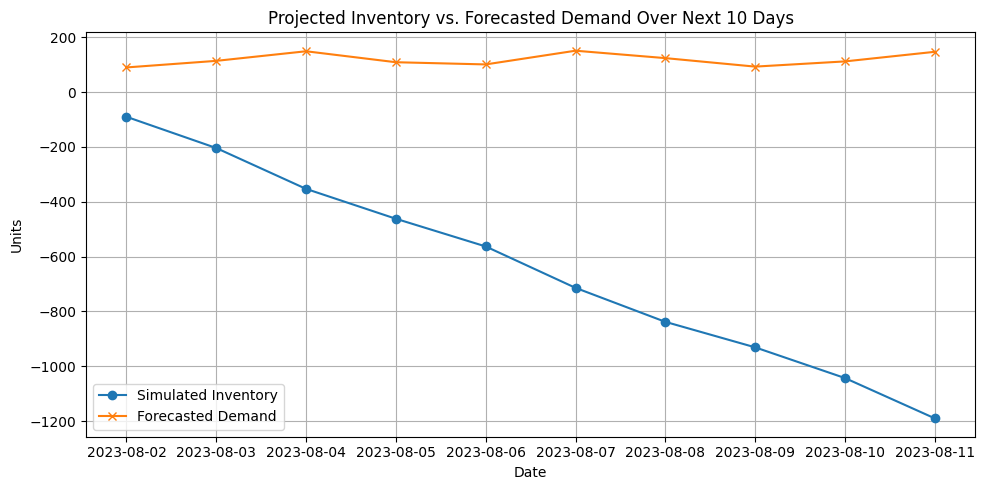

In [23]:
# Simulate day‐by‐day inventory levels if we place no additional order
sim_inventory = [initial_inventory]
for d in future_forecast:
    new_level = sim_inventory[-1] - d
    sim_inventory.append(new_level)

# Drop the initial “duplicate” so that sim_inventory aligns with future_dates
sim_inventory = sim_inventory[1:]

plt.figure(figsize=(10, 5))
plt.plot(future_dates, sim_inventory, marker='o', label='Simulated Inventory')
plt.plot(future_dates, future_forecast, marker='x', label='Forecasted Demand')
plt.title("Projected Inventory vs. Forecasted Demand Over Next 10 Days")
plt.xlabel("Date")
plt.ylabel("Units")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()